# Truck 1: GPS Speed vs. Wheel-Based Speed

#### Imports and global variables are defined here.

In [1]:
# Imports required for this notebook.
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

# Local path to the CSV file containing the data for truck two (2).
truckOnePath = "../data/trucks/truck1.csv"

#### Functions are defined here.

In [2]:
"""Uses Pandas's read_csv method to read a CSV file and returns a DataFrame of it to the notebook.
This function reads in all rows and defines the header row at index 0 by default."""
def readCsv(truck, records = None, headerIdx = 0):
    return pd.read_csv(truck, nrows = records, header = [headerIdx])

##### GPS Speed vs. Wheel-Based Speed

Reading in the truck data; one can change how many records are read by using "records = <#>" in the readCsv function or remove it entirely to read all records.

In [3]:
truckOneDf = readCsv(truckOnePath)
truckOneDf = truckOneDf.ffill().bfill()
#truckOneDf.head()

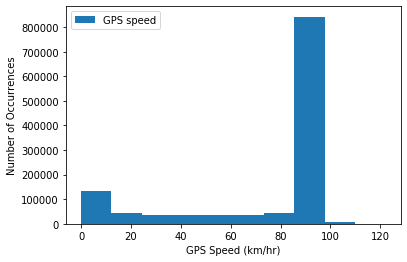

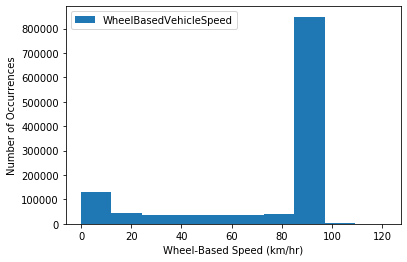

In [4]:
columns = ['GPS speed', 'WheelBasedVehicleSpeed']
gpsSpeedHist = truckOneDf[['GPS speed']].plot.hist(stacked=True)
gpsSpeedHist.set_xlabel('GPS Speed (km/hr)')
gpsSpeedHist.set_ylabel('Number of Occurrences')

wheelSpeedHist = truckOneDf[['WheelBasedVehicleSpeed']].plot.hist(stacked=True)
wheelSpeedHist.set_xlabel('Wheel-Based Speed (km/hr)')
wheelSpeedHist.set_ylabel('Number of Occurrences')

gpsSpeedHist
wheelSpeedHist

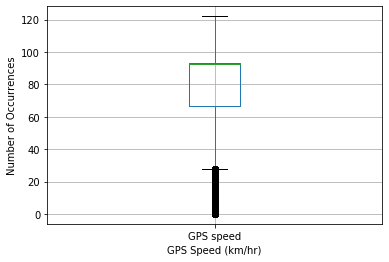

In [5]:
gpsSpeedBox = truckOneDf[['GPS speed']].boxplot()
gpsSpeedBox.set_xlabel('GPS Speed (km/hr)')
gpsSpeedBox.set_ylabel('Number of Occurrences')

gpsSpeedBox

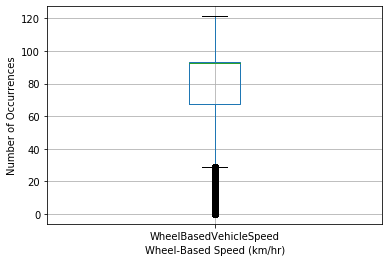

In [6]:
wheelSpeedBox = truckOneDf[['WheelBasedVehicleSpeed']].boxplot()
wheelSpeedBox.set_xlabel('Wheel-Based Speed (km/hr)')
wheelSpeedBox.set_ylabel('Number of Occurrences')

wheelSpeedBox

It's clear that both of these components have a similar trend; there is also definitely a skewness to them. Both of these measurements do have the same axis and appear to be configured correctly.

We can also see that there is a fair amount of readings near zero. We hypothesize that these values are from moments of inactivity, such as stopping at a light or leaving the truck on without moving. Outlier detection is currently being developed and will hopefully snuff these values out.

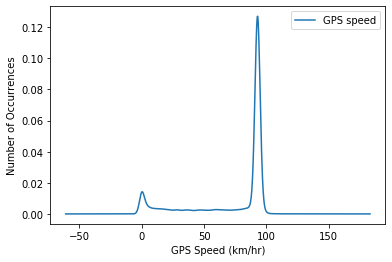

In [7]:
gpsSpeedDist = truckOneDf[['GPS speed']].plot.kde()
gpsSpeedDist.set_xlabel('GPS Speed (km/hr)')
gpsSpeedDist.set_ylabel('Number of Occurrences')

gpsSpeedDist

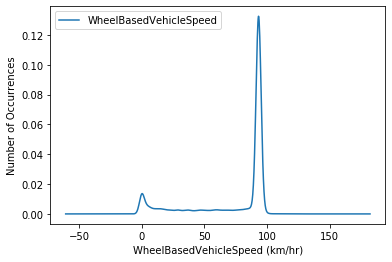

In [8]:
wheelSpeedDist = truckOneDf[['WheelBasedVehicleSpeed']].plot.kde()
wheelSpeedDist.set_xlabel('WheelBasedVehicleSpeed (km/hr)')
wheelSpeedDist.set_ylabel('Number of Occurrences')

wheelSpeedDist

At this point, since we haven't removed outliers or the movements of zero (stopped), there are about two peaks which means that the raw data is showing bimodal trends. This would typically indicate that there are two groups within the data set; this data could technically have two groups: a stopped state and a moving state, where stopped represents all of the points near zero and the moving state represents all of the points near the right peak.

Based on what the raw data contains, it appears that this truck does not reach 0 km/hr very often. This could indicate that truck 1 is the "long-haul" truck. This would be logical because of the relatively high speed in such high quantity in the rightmost peak as compared to the very small leftmost peak near zero (0) would be explained by being on an interstate for long periods of time.